In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [2]:
batch_size = 64
img_height = 180
img_width = 180

#El tamaño de la imagen es de 180x180 pixeles y el batch size es de 64
#para definir el batch size se debe tener en cuenta la memoria RAM del equipo, ya que es el numero de imagenes con las que se trabajaran POR ITERACION 


In [3]:
#nwe hace referencia a la ruta del directorio donde se encuentran las imagenes o el dataset

nwe = './NewData'

#Aca se cargan las imagenes para el entrenamiento
train_ds = tf.keras.utils.image_dataset_from_directory(
  nwe,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  nwe,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 735 files belonging to 10 classes.
Using 588 files for training.
Found 735 files belonging to 10 classes.
Using 147 files for validation.


In [4]:
#IMPORTANTE EJECUTAR para obtener el nombre de las clases
class_names = train_ds.class_names
print(class_names)

['Cerveza', 'agua', 'deportivas', 'energeticas', 'jugo', 'leche', 'refrescos', 'suero', 'te_helado', 'yogurth']


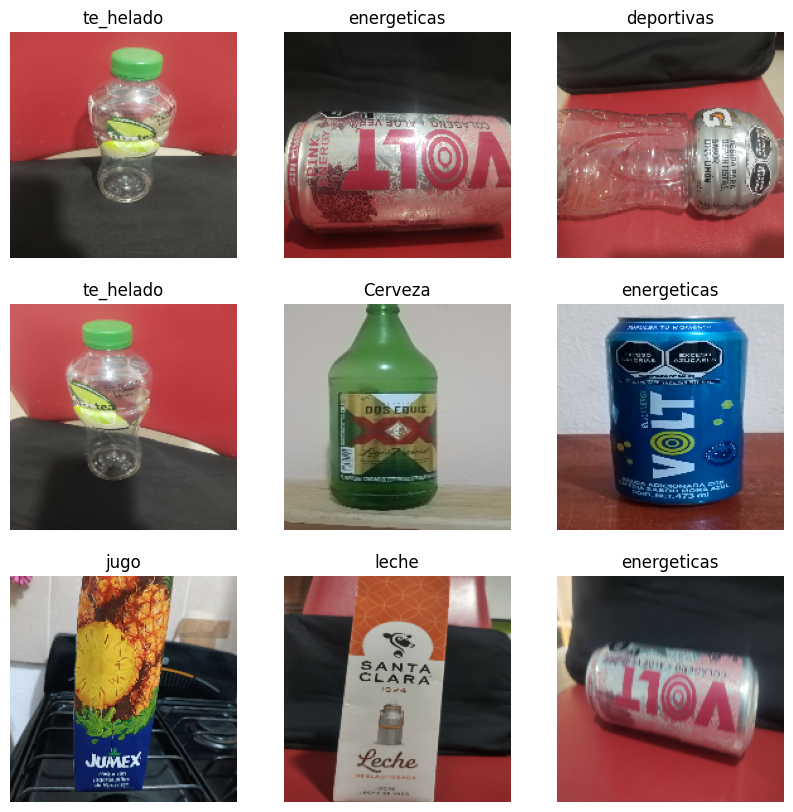

In [5]:
#Esto es opcional, solo para ver las imagenes que tenemos en nuestro dataset
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    

In [6]:
#Esto es relativo, en nuestro caso estamos usando un modelo que si requiere un aumento de datos, entonces hay que ejecutarlo

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
  ]
)


In [7]:
#info de las imagenes
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(64, 180, 180, 3)
(64,)


In [8]:

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
#normalizacion de datos

normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))


0.014956546 1.0


In [10]:
#construcion del modelo


from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

from keras.models import load_model


# Cargar el modelo guardado en formato h5
# model_path = 'ruta_del_modelo/modelo.h5'
# loaded_model = load_model(model_path)

num_classes = len(class_names)

model = keras.Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(50, activation='relu'),
    layers.Dense(10, activation='softmax')
])



In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [12]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [13]:
epochs=100

#Si se prefiere usar un modelo h5 se puede cargar con el siguiente código. Descomentar y cambiar la ruta del modelo
# model_trained_path= './modelo.h5'
# model_trained = load_model(model_trained_path)
#y para asegurar su uso, simplemente se cambia el nombre de la variable model por model_trained

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100


c:\Users\cousi\OneDrive\Escritorio\act3\carros\Lib\site-packages\keras\src\backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


10/10 [==============================] - 11s 997ms/step - loss: 2.3672 - accuracy: 0.1378 - val_loss: 2.0154 - val_accuracy: 0.2857
Epoch 2/100
10/10 [==============================] - 11s 1s/step - loss: 2.0594 - accuracy: 0.2058 - val_loss: 1.8932 - val_accuracy: 0.3469
Epoch 3/100
10/10 [==============================] - 10s 1s/step - loss: 1.8384 - accuracy: 0.3265 - val_loss: 1.7831 - val_accuracy: 0.3129
Epoch 4/100
10/10 [==============================] - 8s 887ms/step - loss: 1.6723 - accuracy: 0.3605 - val_loss: 1.7032 - val_accuracy: 0.3878
Epoch 5/100
10/10 [==============================] - 8s 817ms/step - loss: 1.4666 - accuracy: 0.4592 - val_loss: 1.5196 - val_accuracy: 0.4490
Epoch 6/100
10/10 [==============================] - 8s 801ms/step - loss: 1.3656 - accuracy: 0.4966 - val_loss: 1.5172 - val_accuracy: 0.4286
Epoch 7/100
10/10 [==============================] - 8s 801ms/step - loss: 1.2970 - accuracy: 0.5612 - val_loss: 1.3716 - val_accuracy: 0.5102
Epoch 8/100
10

In [14]:
#Esto es opcional pero es bueno para ver el resumen del modelo, aca estan los datos del accuracy y loss
#se tiene que cambiar el nombre 'history2.npy' por el nombre deseado siempre con .npy al final
np.save('history2.npy',history.history)
history1=np.load('history2.npy',allow_pickle='TRUE').item()

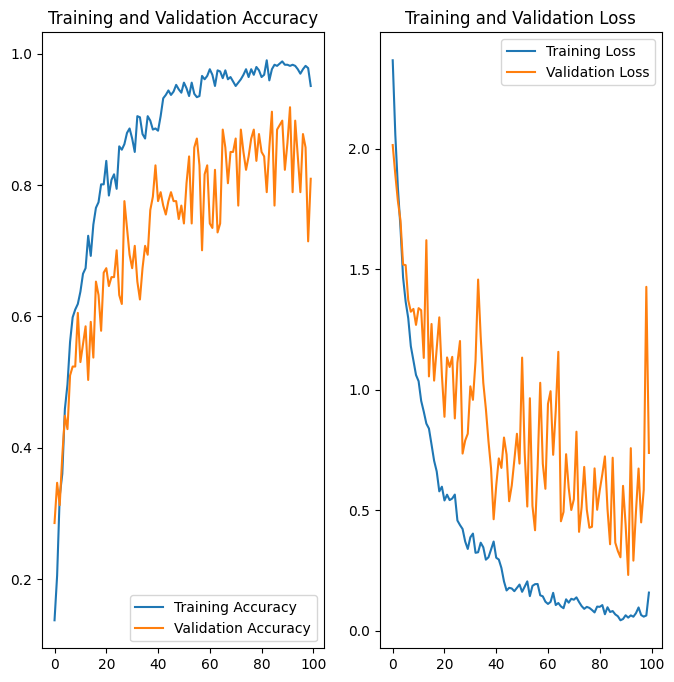

In [15]:
#En esta parte se extraen los datos del accuracy y loss para graficarlos y ver como se comporta el modelo
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
                
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
#Este trozo de codigo es completamente opcional para ejecutar, aqui solo cargamos una imagen y predecimos que es
coin_path = "./aja.jpeg"
img = tf.keras.utils.load_img(
    coin_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


3/3 [==============================] - 1s 101ms/step


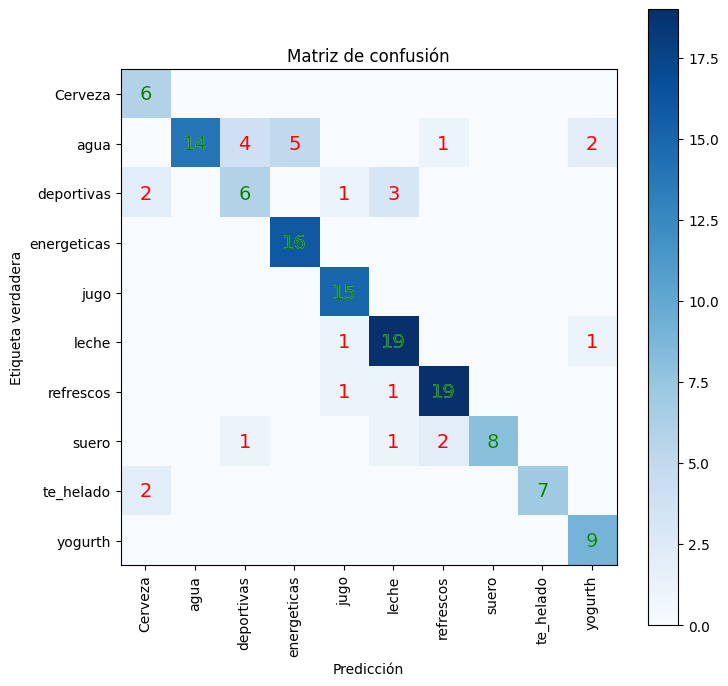

In [16]:
#Este trozo de codigo calcula una matriz de confusion para ver que tan bien se comporta el modelo

y_pred = np.argmax(model.predict(val_ds), axis=1)
y_true = np.concatenate([y for x, y in val_ds], axis=0)
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 

plt.figure(figsize=(8,8))
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de confusión')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta verdadera')

correct_predictions = np.zeros(num_classes)
total_predictions = np.zeros(num_classes)
for i in range(len(y_true)):
    if y_true[i] == y_pred[i]:
        correct_predictions[y_true[i]] += 1
    total_predictions[y_true[i]] += 1
for i in range(num_classes):
    plt.text(i, i, int(correct_predictions[i]), ha="center", va="center", color="white", fontsize=14)
    for j in range(num_classes):
        if confusion_mtx[i, j] > 0 and i != j:
            plt.text(j, i, int(confusion_mtx[i, j]), ha="center", va="center", color="red", fontsize=14)
        if confusion_mtx[i, j] > 0 and i == j:
            plt.text(j, i, int(correct_predictions[i]), ha="center", va="center", color="green", fontsize=14)

plt.show()



In [ ]:
#Este codigo es la interfaz de usuario para poder cargar una imagen y predecir que es


import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import tensorflow as tf
import numpy as np

model = tf.keras.models.load_model('new model ok v6.h5')

def open_image():
    global img_array, tk_image
    file_path = filedialog.askopenfilename()
    img = tf.keras.utils.load_img(file_path, target_size=(180, 180))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    # Mostrar la imagen en la interfaz
    tk_image = ImageTk.PhotoImage(Image.open(file_path).resize((300, 300)))
    image_label.configure(image=tk_image)
    image_label.image = tk_image
    
def show_text():
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])    
    sorted_indexes = np.argsort(score)[::-1]
    text = "La imagen puede clasificarse como:\n\n"
    for i in range(len(class_names)):
        class_name = class_names[sorted_indexes[i]]
        class_score = 100 * score[sorted_indexes[i]]
        text += f"{class_name}: {class_score:.2f}%\n"
    text_label.configure(text=text)
root = tk.Tk()  
root.title("Clasificación de imágenes")
image_label = tk.Label(root)
image_label.pack()
text_label = tk.Label(root, font=("Helvetica", 16))
text_label.pack()
button = tk.Button(root, text="Abrir imagen", command=open_image)
button.pack()
text_button = tk.Button(root, text="Mostrar texto", command=show_text)
text_button.pack()

root.mainloop()


In [17]:
#Con esta linea se guarda el modelo, simplemente hay que tener cuidado con el nombre, no queremos reemplazar el modelo anterior
model.save('new model ok v6.h5')

c:\Users\cousi\OneDrive\Escritorio\act3\carros\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import numpy as np
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.models import load_model

# Obtener los datos y las etiquetas como arrays de NumPy, esto es necesario para usar la validación cruzada ya que 
# si cargamos las imagenes como en el tercer bloque, los datos no estaran en el formato correcto 

X_train = np.concatenate([x for x, y in train_ds], axis=0)
y_train = np.concatenate([y for x, y in train_ds], axis=0)
X_val = np.concatenate([x for x, y in val_ds], axis=0)
y_val = np.concatenate([y for x, y in val_ds], axis=0)

def load_model_fn():
    #Aqui cargamos el modelo entrenado y lo devolvemos
    model_path = './new model ok v6.h5'
    loaded_model = load_model(model_path)
    print(loaded_model.summary())
    return loaded_model

#Aqui inicia el proceso de validacion cruzada, en donde cv es el numero de folds que se usaran para la validacion cruzada
keras_model = KerasClassifier(build_fn=load_model_fn, epochs=40, batch_size=32)
scores = cross_val_score(keras_model, X_train, y_train, cv=7)

mean_score = np.mean(scores)
plt.bar(range(len(scores)), scores)
plt.axhline(y=mean_score, color='r', linestyle='-')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('Cross-validation scores')
plt.show()


In [ ]:
#Esta linea carga los datos del modelo entrenado que serian el accuracy y la loss, simplemente por si se tiene que usar, no es obligatorio ejecutar
array = np.load('./history1.npy',allow_pickle=True)
print(array)